# Model notation and visualization

If you want to communicate the results of an analysis, you should also communicate the
model you used. A common notation to succinctly represent probabilistic models is:

$$ \begin{gathered}
  \theta \sim Beta\left( {\alpha ,\beta } \right) \hfill \\
  y\sim Bin\left( {n = 1,p = \theta } \right) \hfill \\ 
\end{gathered} $$

The very same model can be represented graphically using Kruschke's
diagrams:

<img src="https://parisnanterrefr.sharepoint.com/sites/StatistiqueetanalyseBaysienne/Supports%20de%20cours/krucher.svg" width="200" height="200" />

Read how to create these diagrams [here](http://www.sumsar.net/blog/2013/10/diy-kruschke-style-diagrams/).

# Summarizing the posterior

The result of a Bayesian analysis is a posterior distribution, and all the information about
the parameters given a dataset and a model is contained in the posterior distribution. Thus,
by summarizing the posterior, we are summarizing the logical consequences of a model
and data. A common practice is to report, for each parameter, the mean (or mode or
median) to have an idea of the location of the distribution and some measure, such as the
standard deviation, to have an idea of the dispersion and hence the uncertainty in our
estimate. The standard deviation works well for normal-like distributions but can be
misleading for other type of distributions, such as skewed ones. So, an alternative is to use
the following measure.

## Highest-Posterior Density (HPD)

A commonly-used device to summarize the spread of a posterior distribution is to use a
Highest-Posterior Density (HPD) interval (the interval is often denoted by HDI). 
An HPI is the shortest interval containing a given portion of the probability density. 
One of the most commonly-used is the 95% HPD, often accompanied by the 50% HPD. 
If we say that the 95% HPD for some analysis is [2-5],
we mean that according to our data and model, we think the parameter in question is
between 2 and 5 with a probability of 0.95.

The package ArviZ has many functions to help us summarize the posterior, for example, 
`az.plot_posterior` can be used to generate a plot with the mean and HPD of a distribution. 

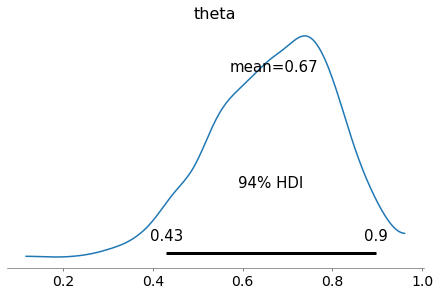

In [1]:
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
# Generate 1000 samples of a Beta(8,4) distribution
data = stats.beta.rvs(8, 4, size=1000)
# Plot the distribution, with its mean and the HDI
result = az.plot_posterior(data={'theta':data}, var_names='theta')
plt.show()

By default, the reported HPD is 94%. This is a friendly remainder of the
arbitrary nature of the 95% value. Every time ArviZ computes and reports a HPD, it will
use, by default, a value of 0.94 (corresponding to 94%). You can change this by passing a
different value to the `hdi_prob` argument, like this

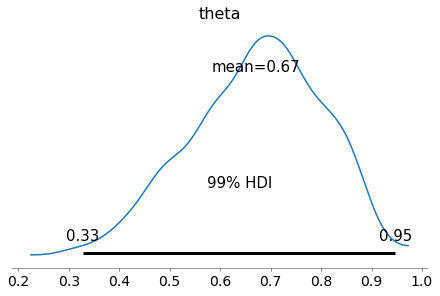

In [2]:
import arviz as az
import matplotlib.pyplot as plt
from scipy import stats
# Let's generate 1000 samples of a Beta(8,4) distribution
data = stats.beta.rvs(8, 4, size=1000)
# Plot the distribution, with its mean and the HDI, specifying a 99% of 
result = az.plot_posterior(data={'theta':data}, var_names='theta', hdi_prob=0.99)
plt.show()

Please note that HPD intervals are not the same as confidence intervals. The HPD has a very
intuitive interpretation, to the point that people often misinterpret frequentist confidence 
intervals as if they were Bayesian credible intervals. Performing a fully-Bayesian analysis 
enables us to talk about the probability of a parameter having some value. This is not 
possible in the frequentist framework since parameters are fixed by design; a frequentist
confidence interval contains or does not contain the true value of a parameter.

# Programming Probabilistically: finding the posterior via PyMC3

The basic idea is to specify models using
code and then solve them in a more or less automatic way. One important
reason behind this choice is that many models do not lead to an analytic closed form, and
thus we can only solve those models using numerical techniques. 

Probabilistic programming offers an effective way to build and solve
complex models and allows us to focus more on model design, evaluation, and
interpretation, and less on mathematical or computational details.

We are going to use **PyMC3**, a very flexible Python library for
probabilistic programming, as well as **ArviZ**, a Python library that will help us
interpret the results of probabilistic models. Knowing **PyMC3** and **ArviZ** will also help us
to learn advanced Bayesian concepts in a more practical way.

Bayesian statistics is conceptually very simple; we have the knows and the unknowns; we use
Bayes' theorem to condition the latter on the former. If we are lucky, this process will
reduce the uncertainty about the unknowns. Generally, we refer to the knowns as data and
treat it like a constant, and the unknowns as parameters and treat them as probability
distributions. In more formal terms, we assign probability distributions to unknown
quantities. Then, we use Bayes' theorem to transform the prior probability distribution
into a posterior distribution . Although conceptually simple, fully probabilistic
models often lead to analytically intractable expressions. For many years, this was a real
problem and was probably one of the main issues that hindered the wide adoption of
Bayesian methods.

The arrival of the computational era and the development of numerical methods that, at
least in principle, can be used to solve any inference problem, has dramatically transformed
the Bayesian data analysis practice. We can think of these numerical methods as universal
inference engines. The possibility of automating the inference process has led to the
development of probabilistic programming languages (PPL), which allows for a clear
separation between model creation and inference.

In the PPL framework, users specify a full probabilistic model by writing a few lines of
code, and then inference follows automatically. It is expected that probabilistic
programming will have a major impact on data science and other disciplines by enabling
practitioners to build complex probabilistic models in a less time-consuming and less error-
prone way. I think one good analogy for the impact that programming languages can have
on scientific computing is the introduction of the Fortran programming language more than
six decades ago. While nowadays Fortran has lost its shine, at one time, it was considered
to be very revolutionary. For the first time, scientists moved away from computational
details and began focusing on building numerical methods, models, and simulations in a
more natural way. In a similar fashion, we now have PPL, which hides details on how
probabilities are manipulated and how the inference is performed from users, allowing
users to focus on model specification and the analysis of results.

## PyMC3 & Co

**PyMC3** is a Python library for probabilistic programming. **PyMC3** provides a very simple and 
intuitive syntax that is easy to read and that is close to the syntax used in the statistical 
literature to describe probabilistic models. **PyMC3**'s base code is written using Python, 
and the computationally demanding parts are written using **NumPy** and **Theano**.

**Theano** is a Python library that was originally developed for deep learning and allows us
to define, optimize, and evaluate mathematical expressions involving multidimensional
arrays efficiently. The main reason **PyMC3** uses **Theano** is because some of the sampling
methods, such as NUTS, need gradients to be computed, and Theano knows how to
compute gradients using what is known as automatic differentiation. Also, Theano
compiles Python code to C code, and hence **PyMC3** is really fast.

If you like to know more about the future of **Theano** and **PyMC3** read this [blog post](https://pymc-devs.medium.com/the-future-of-pymc3-or-theano-is-dead-long-live-theano-d8005f8a0e9b).

## Coin flipping problem with PyMC3

Remember the coin flipping problem we discussed last class:

We want to study the probability $\theta$ that when a coin is tossed it lands heads. After 10 tosses these are the results

{1,1,1,0,1,1,0,0,1,1}

We will use a non informative prior.

We saw that the posterior distribution for $\theta$ given the data, is a Beta(8,4).

The following code solves the same probelm numerically

In [3]:
# Import pymc3
import pymc3 as pm
# This is just the data
data = [1,1,1,0,1,1,0,0,1,1]

# This line is just to initialize the model
with pm.Model() as coin_flipping_model:
    # The following line defines the prior, theta distributes as Beta(1,1)
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # The following line defines the likelihood Bernoulli with p=theta
    y = pm.Bernoulli('y', p=theta, observed=data)
    # This line generates 1000 samples of the posterior
    trace = pm.sample(1000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 23 seconds.


Let's analyze in detail the code

````python
# This line is just to initialize the model
with pm.Model() as coin_flipping_model:
    # The following line defines the prior, theta distributes as Beta(1,1)
    theta = pm.Beta('theta', alpha=1., beta=1.)
    # The following line defines the likelihood Bernoulli with p=theta
    y = pm.Bernoulli('y', p=theta, observed=data)
    # This line generates 1000 samples of the posterior
    trace = pm.sample(1000)
````

The line

````python
with pm.Model() as coin_flipping_model:
````

creates a container for our model. Everything inside the with-
block will be automatically added to `coin_flipping_model` . You can think of this as syntactic
sugar to ease model specification as we do not need to manually assign variables to the
model. 

The line 

````python
theta = pm.Beta('theta', alpha=1., beta=1.)
````

specifies the prior. As you can see, the syntax follows the
mathematical notation closely.

Note that we use the name theta twice, first as a Python variable and
then as the first argument of the Beta function; using the same name is a
good practice to avoid confusion. The theta variable is a random variable; it is
not a number, but an object representing a probability distribution from
which we can compute random numbers and probability densities.

The line 

````python
y = pm.Bernoulli('y', p=theta, observed=data)
````

specifies the likelihood. The syntax is almost the same as for the prior, except
that we pass the data using the observed argument. This is the way in which we tell
**PyMC3** that we want to condition for the unknown on the knows (data). The observed
values can be passed as a Python list, a tuple, a NumPy array, or a pandas DataFrame.

The last line

````python
trace = pm.sample(1000)
````

is the inference button. We are asking for 1,000 samples from the posterior and
will store them in the trace object.

Now, let's analyze the ourput 

`
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
`

The first and second lines tell us that **PyMC3** has automatically assigned the NUTS sampler
(one inference engine that works very well for continuous variables), and has used a
method to initialize that sampler. The third line says that **PyMC3** will run 4 chains in
parallel, thus we will get 4 independent samples from the posterior for the price of one.

The exact number of chains is computed taking into account the number of processors in
your machine, you can change it using the `chains` argument for the sample function. The
next line is telling us which variables are being sampled by which sampler. For this
particular case, this line is not adding new information. Because NUTS is used to sample the
only variable we have `theta` . However, this is not always the case as **PyMC3** can assign different
samplers to different variables. This is done automatically by **PyMC3** based on properties
of the variables that ensures that the best possible sampler is used for each variable. Users
can manually assign samplers using the `step` argument of the sample function.

## Summarizing the posterior

Generally, the first task we will perform after sampling from the posterior is check what the
results look like. The `plot_trace` function from ArviZ is ideally suited to this task:

C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


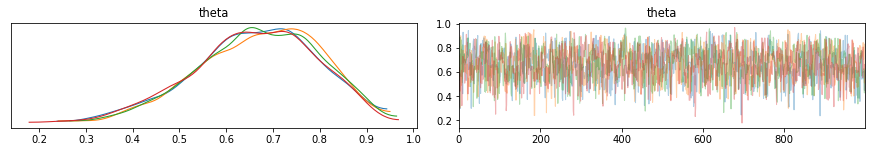

In [4]:
import arviz as az
result = az.plot_trace(trace)
plt.show()

By using `az.plot_trace`, we get two subplots for each unobserved variable. The only
unobserved variable in our model is theta. Notice that y is an observed variable representing
the data; we do not need to sample that because we already know those values. Thus, in the figure, we have two subplots. On the left, we have a **Kernel Density Estimation (KDE)**
plot; this is like the smooth version of the histogram. On the right, we get the individual
sampled values at each step during the sampling. From the trace plot, we can visually get
the plausible values from the posterior. 

We may also want to have a numerical summary of the trace. We can get
that using `az.summary`, which will return a pandas DataFrame:

In [5]:
az.summary(trace)

C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
theta,0.666,0.13,0.414,0.889,0.003,0.002,1752.0,1671.0,1740.0,2856.0,1.0


We get the `mean`, `standard deviation` (sd), and 94% HPD interval (hpd 3% and hpd 97%).
We can use these numbers to
interpret and report the results of a Bayesian inference.

Another way to visually summarize the posterior is to use the `plot_posterior` function:

C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


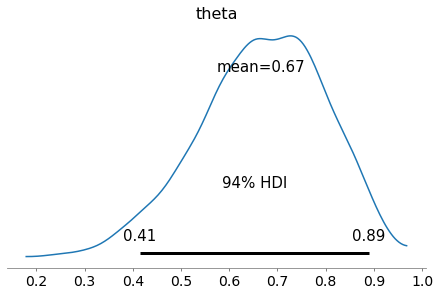

In [6]:
result = az.plot_posterior(trace)
plt.show()

We can compare this plot with the theoretical pdf of the posterior (remember is Beta(8,4)).

C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


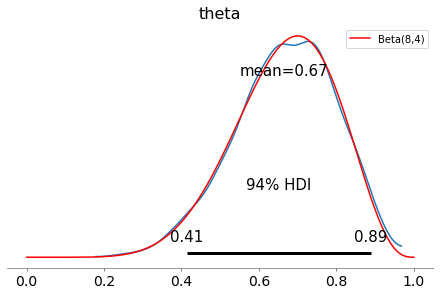

In [7]:
import numpy as np
# Plot the distribution, with its mean and the HDI
ax = az.plot_posterior(trace, show=False)[0]
# Plot the distribution, with its mean and the HDI
x = np.linspace(0, 1, 100)
y = stats.beta(8, 4).pdf(x)
ax.plot(x, y, label='Beta(8,4)', color='r')
ax.legend()
plt.show()

## Posterior based decisions

Sometimes, describing the posterior is not enough. Sometimes, we need to make decisions
based on our inferences. We have to reduce a continuous estimation to a dichotomous one:
yes-no, health-sick, contaminated-safe, and so on. We may need to decide if the coin is fair
or not. A fair coin is one with a value of theta exactly 0.5. We can compare the value of 0.5
against the HPD interval. In the previous figure, we can see that the HPD goes from ≈0.43 to ≈0.9
and hence 0.5 is included in the HPD. According to our posterior, the coin seems to be tail-
biased, but we cannot completely rule out the possibility that the coin is fair. If we want a
sharper decision, we will need to collect more data to reduce the spread of the posterior or
maybe we need to find out how to define a more informative prior.

### ROPE

Strictly speaking, the chance of observing exactly 0.5 (that is, with infinite trailing zeros) is
zero. Also, in practice, we generally do not care about exact results, but results within a
certain margin. Accordingly, in practice, we can relax the definition of fairness and we can
say that a fair coin is one with a value of around 0.5. For example, we could say that any
value in the interval [0.45, 0.55] will be, for our purposes, practically equivalent to 0.5. We
call this interval a **Region Of Practical Equivalence** (ROPE). Once the ROPE is defined, we
compare it against the **Highest-Posterior Density** (HPD). We can get at least three
scenarios:

* The ROPE does not overlap with the HPD; we can say the coin is not fair.
* The ROPE contains the entire HPD; we can say the coin is fair.
* The ROPE partially overlaps with HPD; we cannot say the coin is fair or unfair.

If we choose a ROPE in the interval [0, 1], we will always say we have a fair coin. Notice
that we do not need to collect data to perform any type of inference. Of course, this is a
trivial, unreasonable, and dishonest choice and probably nobody is going to agree with our
ROPE definition. I am just mentioning it to highlight the fact that the definition of the ROPE
is context-dependent; there is no auto-magic rule that will fit everyone's intentions.
Decisions are inherently subjective and our mission is to take the most informed possible
decisions according to our goals.

C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


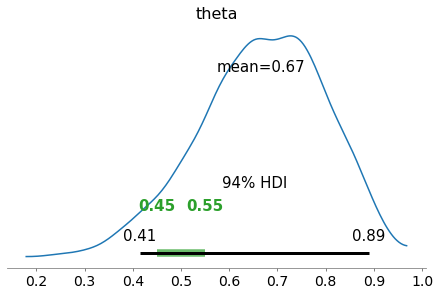

In [8]:
result = az.plot_posterior(trace, rope=[0.45, 0.55])
plt.show()

Another tool we can use to help us make a decision is to compare the posterior against a
reference value. We can do this using plot_posterior . As you can see, we get a vertical
(orange) line and the proportion of the posterior above and below our reference value:

C:\Users\carlo\miniconda3\envs\bayesianStats\lib\site-packages\arviz\data\io_pymc3.py:89: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


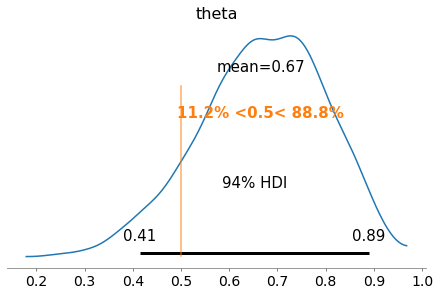

In [9]:
result = az.plot_posterior(trace, ref_val=0.5)
plt.show()